In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
savedir = '32x32-convnet-scrambled-targets'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=512):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::2,::2].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.
order = np.random.permutation(range(64*64))

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

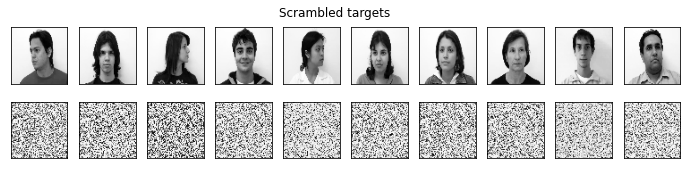

In [8]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled targets')

for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(train_targets[i].view(-1)[order].view(64,64),cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])
    
train_targets = train_targets.view(-1,64*64)[:,order].view(-1,64,64)
val_targets = val_targets.view(-1,64*64)[:,order].view(-1,64,64)
test_targets = test_targets.view(-1,64*64)[:,order].view(-1,64,64)

In [9]:
batch_size = 8

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 479309825 parameters
Initial Loss: 4.071708


In [10]:
batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.529742	2.294151	86.566705	2.355360
1	1.278518	2.926466	92.172530	2.475708
2	1.187599	2.363746	93.170723	2.494826
3	1.108557	2.099249	93.361729	2.499852
4	1.060318	1.686299	93.147466	2.471466
5	1.027562	1.793732	92.364710	2.474752
6	0.967304	1.723334	92.385769	2.464056
7	0.918213	1.738622	92.353280	2.458598
8	0.850233	1.686232	92.383152	2.464293
9	0.799326	1.597996	92.376637	2.453009
10	0.749638	1.479633	92.444020	2.465971
11	0.715308	1.642009	92.424797	2.473272
12	0.678137	1.408897	92.445107	2.469403
13	0.648884	1.270252	92.447882	2.468260
14	0.614619	1.090474	92.497011	2.467071
15	0.585142	1.188463	92.460496	2.453914
16	0.555365	1.244635	92.471562	2.467765
17	0.525280	1.109380	92.494732	2.469872
18	0.500050	0.982428	92.566402	2.473255
19	0.471791	1.277171	92.547632	2.465736
20	0.453648	1.044588	92.532854	2.471099
21	0.438888	1.048247	92.516440	2.461424
22	0.419239	1.064991	92.498721	2.470739
23	0.399201	1.016914	92.491918	2.472980
24	0.381054

202	0.011870	0.959075	92.434579	2.461632
203	0.012730	0.832729	92.369721	2.464127
204	0.012896	1.019297	92.372817	2.449532
205	0.012337	0.891490	92.378659	2.461218
206	0.012515	0.921545	92.385588	2.457042
207	0.011527	0.991573	92.365598	2.457271
208	0.011210	0.946243	92.363344	2.456518
209	0.010643	0.939112	92.356576	2.460530
210	0.010815	0.950673	92.409000	2.465827
211	0.011148	0.902129	92.369654	2.446655
212	0.011586	1.012834	92.426714	2.467358
213	0.011774	0.923865	92.341399	2.468323
214	0.011888	0.930941	92.389753	2.453480
215	0.011623	0.919393	92.406331	2.458026
216	0.011231	0.833636	92.350890	2.467194
217	0.010530	0.904222	92.356300	2.461687
218	0.010125	0.879662	92.360654	2.450609
219	0.009746	0.913331	92.375396	2.469752
220	0.009825	0.946866	92.380906	2.464473
221	0.010279	0.951971	92.393399	2.460351
222	0.010408	0.884163	92.363828	2.459570
223	0.010509	0.951919	92.385065	2.460300
224	0.010643	1.021470	92.384653	2.451888
225	0.010903	0.956994	92.361366	2.458405
226	0.010623	0.8

402	0.005237	0.940127	92.295942	2.454427
403	0.004894	0.957947	92.321023	2.470959
404	0.004562	0.828022	92.318314	2.468175
405	0.004626	0.990016	92.311380	2.458440
406	0.004577	0.865796	92.328758	2.447746
407	0.004682	1.029780	92.299992	2.465306
408	0.004718	0.955036	92.315875	2.462924
409	0.004721	0.881223	92.309241	2.463442
410	0.004903	0.890223	92.311695	2.461724
411	0.005285	0.986088	92.291901	2.465433
412	0.006042	0.949242	92.291606	2.462072
413	0.005591	0.881903	92.306498	2.465089
414	0.005065	0.928235	92.259166	2.470636
415	0.004247	0.883427	92.300151	2.451783
416	0.003915	0.889424	92.286674	2.440809
417	0.003984	0.953635	92.300733	2.456172
418	0.004353	0.957468	92.319409	2.461476
419	0.005172	0.859509	92.311957	2.469955
420	0.005881	0.995222	92.347684	2.450090
421	0.006163	0.990976	92.354033	2.462597
422	0.005234	1.014359	92.329565	2.470425
423	0.004258	0.980972	92.259182	2.473325
424	0.003809	0.958014	92.342419	2.451054
425	0.003614	0.816930	92.320517	2.451631
426	0.003803	1.0

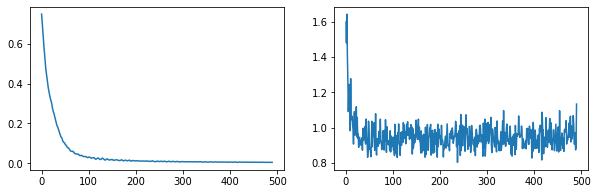

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(train_history[10:])
ax[1].plot(val_history[10:])

In [12]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 72.634575


In [13]:
invorder = np.array(sorted(zip(range(64*64),order),key=lambda x: x[1]))[:,0]

In [29]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/scrambled-targets')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].cuda()).detach().cpu()[0]
    recon = recon.view(64*64)[invorder].view(64,64).numpy() # descramble
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        target = targets[i].view(64*64)[order].view(64,64).numpy() # scramble
        cv2.imwrite(f'final-outputs/scrambled-targets/{prefix}-person{person}-pose{pose}.png', 255*target)

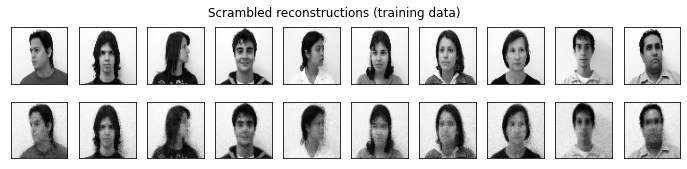

In [20]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled reconstructions (training data)')

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

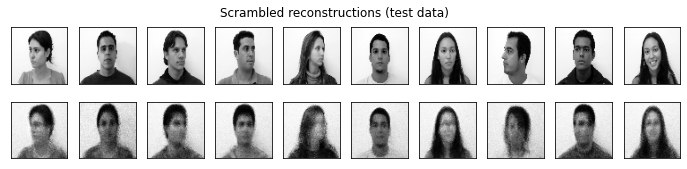

In [21]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled reconstructions (test data)')

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])